In [35]:
import torch 
import torch_geometric as pyg
import pandas as pd
import numpy as np
import omnipath as op 
from matplotlib import pyplot as plt 
import torch_geometric as pyg 
import copy 
import umap
from sklearn.decomposition import PCA
import seaborn as sbn

from gsnn.reinforce.Actor import Actor
from gsnn.reinforce.Environment import Environment
from gsnn.models.GSNN import GSNN
from gsnn.data.LincsDataset import LincsDataset
from gsnn.models import utils 
from gsnn.proc.utils import get_x_drug_conc             # required to unpickle data 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
result_dict = torch.load('../../output/rl_results_dict.pt')
NS = result_dict['actor']
NS.load_state_dict(result_dict['state_dict'])
data = result_dict['data']

row,col = data.edge_index_dict['function','to','function']
N = len(data.node_names_dict['function'])

uni2sym = pd.read_csv('../../extdata/omnipath_uniprot2genesymb.tsv', sep='\t')

res = pd.DataFrame({'src':np.array(data.node_names_dict['function'])[row], 'dst':np.array(data.node_names_dict['function'])[col], 'prob':result_dict['node_prob'].ravel()})
res = res.assign(src_uni=lambda x: [xx.split('__')[1] for xx in x.src])
res = res.assign(dst_uni=lambda x: [xx.split('__')[1] for xx in x.dst])
res = res.merge(uni2sym, left_on='src_uni',right_on='From', how='left').rename({'To':'src_name'}, axis=1).drop(['src_uni', 'From'], axis=1)
res = res.merge(uni2sym, left_on='dst_uni',right_on='From', how='left').rename({'To':'dst_name'}, axis=1).drop(['dst_uni', 'From'], axis=1)

#_ = [print(x) for x in res.sort_values('prob', ascending=False).dropna().head(50).To.tolist()]

res.sort_values('prob', ascending=False).head(15)

,src,dst,prob,src_name,dst_name
1370,PROTEIN__P01100,RNA__P15407,1.0,FOS,FOSL1
70277,PROTEIN__Q14209,RNA__MIMAT0000074,1.0,E2F2,NaN
19951,PROTEIN__COMPLEX:O14686_O15047_P61964_Q15291_Q...,PROTEIN__P84243,1.0,NaN,H3-3B
73259,PROTEIN__O15350,RNA__MIMAT0000255,1.0,TP73,NaN
27269,PROTEIN__P04628,PROTEIN__Q01974,1.0,WNT1,ROR2
1108,PROTEIN__P16220,RNA__P13765,1.0,CREB1,HLA-DOB
20026,PROTEIN__Q70E73,PROTEIN__P50552,1.0,RAPH1,VASP
41041,PROTEIN__P50750,PROTEIN__P28799,1.0,CDK9,GRN
80665,RNA__MIMAT0000075,RNA__Q08999,1.0,NaN,RBL2
19933,PROTEIN__P19474,PROTEIN__P49915,1.0,TRIM21,GMPS


In [37]:
res.sort_values('prob', ascending=False).tail(10)

,src,dst,prob,src_name,dst_name
52959,PROTEIN__P22694,PROTEIN__P41240,2.548673e-09,PRKACB,CSK
23324,PROTEIN__P00441,PROTEIN__Q15046,2.460769e-09,SOD1,KARS1
42329,PROTEIN__P49760,PROTEIN__Q8N5S9,2.452227e-09,CLK2,CAMKK1
52043,PROTEIN__P18075,PROTEIN__P01375,2.421445e-09,BMP7,TNF
79726,RNA__MIMAT0005871,RNA__P42226,2.214000e-09,NaN,STAT6
27206,PROTEIN__P06850,PROTEIN__P16473,2.135064e-09,CRH,TSHR
58289,PROTEIN__O15524,PROTEIN__P24394,2.081408e-09,SOCS1,IL4R
54808,PROTEIN__P48061,PROTEIN__P51692,1.815243e-09,CXCL12,STAT5B
10646,PROTEIN__Q9H6S1,PROTEIN__Q9UHD2,1.234210e-09,AZI2,TBK1
79737,RNA__MIMAT0001080,RNA__Q92908,5.138501e-10,NaN,GATA6


In [38]:
row,col = data.edge_index_dict['input', 'to', 'function']
drug_idxs = torch.tensor([i for i,name in enumerate(data.node_names_dict['input']) if 'DRUG__' in name], dtype=torch.long)
dti_idxs = torch.isin(row, drug_idxs).nonzero(as_tuple=True)[0]
targ_idxs = col[dti_idxs]
targs = np.array(data.node_names_dict['function'])[targ_idxs]
print('# targets:', len(targs))
#res[lambda x: x.node_name.isin(targs)].sort_values('prob', ascending=False).head(30) 

# get all output RNAs 
row,col = data.edge_index_dict['function', 'to', 'output']
output_nodes = np.array(data.node_names_dict['function'])[row]
print('# output nodes', len(output_nodes))

# targets: 15
# output nodes 11


In [39]:
output_nodes = [output_nodes]
targs = [targs]
output_nodes

['RNA__P04637']

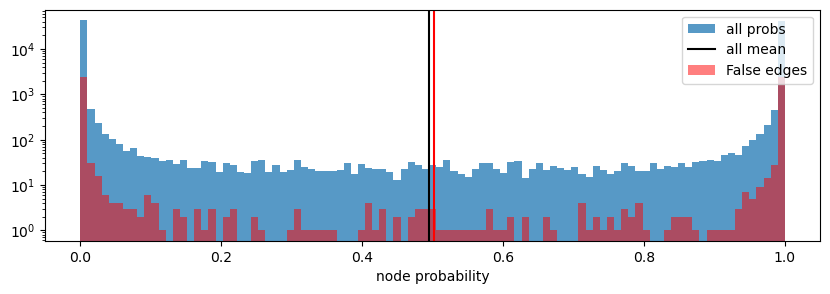

In [40]:
bins = np.linspace(0,1,100)
dens = False

plt.figure(figsize=(10,3))
plt.hist(res.prob, bins=bins, alpha=0.75, density=dens, label='all probs')
#for targ in targs: 
#    plt.axvline(res[lambda x: x.node_name == targ].prob.item(), c='g')
#plt.axvline(res[lambda x: x.node_name.isin(targs)].prob.mean().item(), c='y')
plt.axvline(res.prob.mean(), c='k', label='all mean')
#plt.hist(res[lambda x: x.src.isin(targs)].prob, color='g', bins=bins, alpha=0.5, density=dens, label='targets')
#plt.hist(res[lambda x: x.dst.isin(output_nodes)].prob, color='r', bins=bins, alpha=0.5, density=dens, label='outputs')
##plt.axvline(res[lambda x: x.node_name == 'RNA__P04637'].prob.item(), c='r', label='RNA__TP53')

plt.hist(result_dict['node_prob'][~result_dict['true_edge_mask']], bins=bins, density=dens, alpha=0.5, color='r', label='False edges')
plt.axvline(result_dict['node_prob'][~result_dict['true_edge_mask']].mean(), c='r')
#plt.axvline(res[lambda x: x.src.isin(targs)].prob.mean(), c='g', label='targets mean')
#plt.axvline(res[lambda x: x.dst.isin(output_nodes)].prob.mean(), c='r', label='outputs mean')
plt.xlabel('node probability')
plt.legend()
plt.yscale('log')
plt.show()

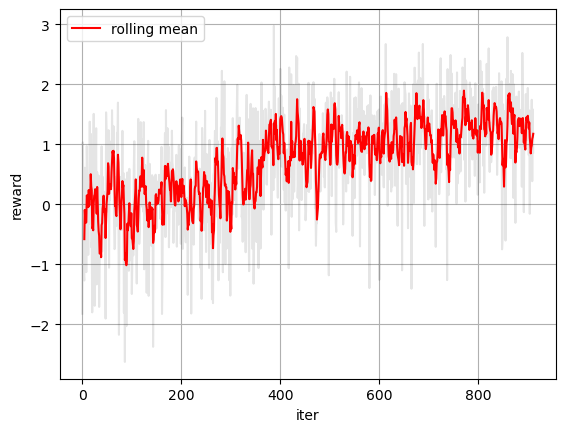

In [41]:
window=5
tmp = pd.DataFrame({'reward':np.stack(result_dict['ppo'].rewards, axis=0).mean(axis=1)})
tmp = tmp.assign(rm = tmp.rolling(window=window).mean(), 
                 rs = tmp.rolling(window=window).std(),
                 q05 = tmp.rolling(window=window).quantile(q=0.05),
                 q25 = tmp.rolling(window=window).quantile(q=0.25), 
                 q75 = tmp.rolling(window=window).quantile(q=0.75), 
                 q95 = tmp.rolling(window=window).quantile(q=0.95), 
                 )

plt.figure()
for i in range(len(result_dict['ppo'].rewards[0])): 
    plt.plot([r[i] for r in result_dict['ppo'].rewards], 'k-', alpha=0.1)

    #tmp2 = pd.DataFrame({'reward':[r[i] for r in result_dict['ppo'].rewards]})
    #tmp2 = tmp2.assign(rm = tmp2.rolling(window=window).mean())
    #plt.plot(tmp2.rm, 'r--')

plt.plot(tmp.rm, 'r-', label='rolling mean')

#plt.fill_between(range(len(tmp.rm)), tmp.q95, tmp.q05, color='b', alpha=0.1, label='rolling 90% CI')
#plt.fill_between(range(len(tmp.rm)), tmp.q75, tmp.q25, color='b', alpha=0.2, label='rolling 50% CI')
#plt.axvline(result_dict['args'].warmup - 1, c='k', label='warmup', alpha=0.5)
plt.legend()
plt.grid()
plt.xlabel('iter')
plt.ylabel('reward')
plt.show()

In [42]:
print('best reward', result_dict['best_reward'])

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(result_dict['true_edge_mask'].detach().cpu().numpy(), np.array(result_dict['best_action'])).ravel()
print('tn:', tn)
print('fp:', fp)
print('fn:', fn)
print('tp:', tp)

best reward 2.9736121253791206
tn: 2536
fp: 2464
fn: 42240
tp: 41814


In [42]:
result_dict = torch.load('../../processed_data/rl_results_dict.pt')

p = np.array(result_dict['node_prob'])
env = result_dict['env']

result_dict.keys()

FileNotFoundError: [Errno 2] No such file or directory: '../../processed_data/rl_results_dict.pt'

In [3]:

env.model_kwargs['checkpoint'] = False
env.train_dataset.root = '../../data/all/'
env.val_dataset.root = '../../data/all/'

n = 10

policy_perf = []
for i in range(n): 
        action = torch.tensor(np.random.binomial(n=1, p=p), dtype=torch.float32)
        policy_perf.append( env.run(action) )

rand_perf = []
for i in range(n): 
    p_ = np.mean(p)*np.ones((len(p),))
    action = torch.tensor(np.random.binomial(n=1, p=p_), dtype=torch.float32)
    rand_perf.append( env.run(action) )

env.batch_size = 100 # probably have to adjust this 
baseline_perf = []
for i in range(n):      
        action = torch.ones((len(p), ), dtype=torch.float32)
        baseline_perf.append( env.run(action) )

res = pd.DataFrame({'policy':['ppo']*n + ['all']*n + ['random']*n, 'perf':policy_perf + baseline_perf + rand_perf})

plt.figure()
sbn.boxplot(x='policy', y='perf', data=res)
plt.show()


KeyboardInterrupt: 

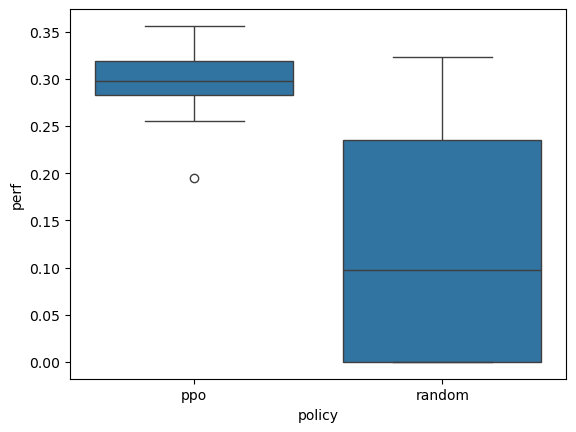

In [7]:
res = pd.DataFrame({'policy':['ppo']*n + ['random']*n, 'perf':policy_perf + rand_perf})

plt.figure()
sbn.boxplot(x='policy', y='perf', data=res)
plt.show()

In [5]:
rand_perf

[0.14082449674606323,
 0.1533355712890625,
 0,
 0,
 0.05491459369659424,
 0,
 0,
 0.32265985012054443,
 0.2618330717086792,
 0.3116953372955322]

In [6]:
baseline_perf

[]

In [17]:
res

,action,perf
0,policy,0.387719
1,policy,0.392071
2,policy,0.167701
3,policy,0.412015
4,policy,0.410178
5,baseline,0.395513
6,baseline,0.377342
7,baseline,0.172750
8,baseline,0.403196
9,baseline,0.375111


In [225]:
rand_perf = []
for i in range(n): 
    p_ = np.mean(p)*np.ones((len(p),))
    action = torch.tensor(np.random.binomial(n=1, p=p_), dtype=torch.float32)
    rand_perf.append( env.run(action) )

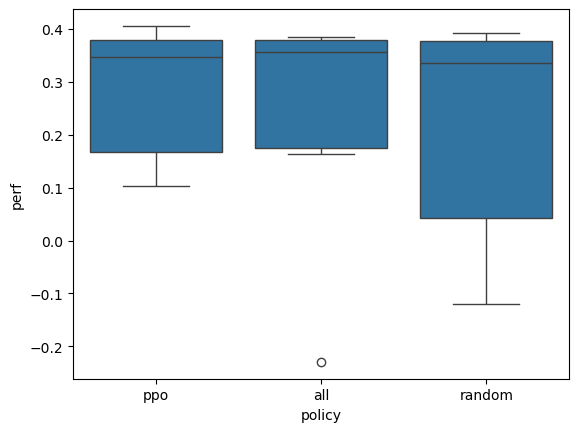

In [228]:
res = pd.DataFrame({'policy':['ppo']*n + ['all']*n + ['random']*n, 'perf':policy_perf + baseline_perf + rand_perf})

plt.figure()
sbn.boxplot(x='policy', y='perf', data=res)
plt.show()


progress: 1/10


progress: 2/10: 6/25 | train loss: 8.8 || val perf: 0.30651
progress: 3/10: 9/25 | train loss: 4.3 || val perf: 0.088973
progress: 4/10: 16/25 | train loss: 6.6 || val perf: -0.033
progress: 5/10: 9/25 | train loss: 12.3 || val perf: 0.373
progress: 6/10: 8/25 | train loss: 5.8 || val perf: 0.354956
progress: 7/10: 12/25 | train loss: 8.4 || val perf: 0.3436
progress: 8/10: 12/25 | train loss: 10.7 || val perf: 0.318
progress: 9/10: 14/25 | train loss: 13.4 || val perf: 0.3228
progress: 10/10 8/25 | train loss: 818.5 || val perf: 0.1075166


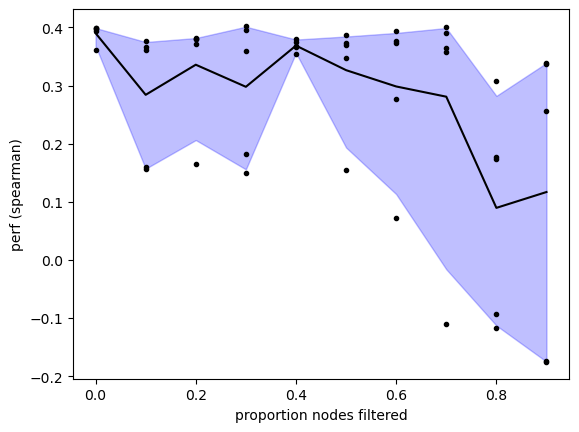

In [223]:
# this should really be done with a test dataset ... 

env.train_dataset.root = '../../processed_data/'
env.val_dataset.root = '../../processed_data/'

qs=np.linspace(0., 0.9, 10)
perfs = []

for i,q in enumerate(qs): 
    print(f'progress: {i+1}/{len(qs)}')
    repls = []
    for j in range(5): 
        t = np.quantile(p, q=[q])[0]
        action = torch.tensor((1.*(p>t)), dtype=torch.float32)
        repls.append( env.run(action) )
    perfs.append(repls)

p_mean = [np.mean(p) for p in perfs]
p_q05 = [np.quantile(p, q=[0.05])[0] for p in perfs]
p_q95 = [np.quantile(p, q=[0.95])[0] for p in perfs]

plt.figure()
plt.plot(qs, p_mean, 'k-')
plt.fill_between(qs, p_q05, p_q95, color='b', alpha=0.25)

for i in range(5): 
    plt.plot(qs, [p[i] for p in perfs], 'k.')

plt.ylabel('perf (spearman)')
plt.xlabel('proportion nodes filtered')
plt.show()